# Pessimistic Neighbourhood Aggregation for States in Reinforcement Learning (Dynamic Grid)

*Author: Maleakhi Agung Wijaya  
Supervisors: Marcus Hutter, Sultan Javed Majeed  
Date Created: 21/12/2017*

In [1]:
import random
import math
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, clear_output

In [2]:
# Set grid color for seaborn
sns.set(style="whitegrid")

## Mountain Car Environment

**Mountain Car** is a standard testing domain in Reinforcement Learning, in which an under-powered car must drive up a steep hill. Since gravity is stronger than the car's engine, even at full throttle, the car cannot simply accelerate up the steep slope. The car is situated in a valley and must learn to leverage potential energy by driving up the opposite hill before the car is able to make it to the goal at the top of the rightmost hill.

**Technical Details**
- *State:* feature vectors consisting of velocity and position represented by an array [velocity, position]
- *Reward:* -1 for every step taken, 0 for achieving the goal
- *Action:* (left, neutral, right) represented by (-1, 0, 1)
- *Initial state:* velocity = 0.0, position = -0.5 represented by [0.0, -0.5]
- *Terminal state:* position >= 0.6
- *Boundaries:* velocity = (-0.07, 0.07), position = (-1.2, 0.6)
- *Update function:* velocity = velocity + (Action) \* 0.001 + cos(3\*Position) * (-0.0025), position = position + velocity

In [3]:
class MountainCarEnvironment:
    """
    Description: Environment for Mountain Car problem, adapted from Sutton and Barto's Introduction to Reinforcement Learning.
    Author: Maleakhi Agung Wijaya
    """
    VELOCITY_BOUNDARIES = (-0.07, 0.07)
    POSITION_BOUNDARIES = (-1.2, 0.6) 
    
    INITIAL_VELOCITY = 0.0
    INITIAL_POSITION = -0.5
    
    REWARD_STEP = -1
    REWARD_TERMINAL = 0
   
    # Constructor for MountainCarEnvironment
    # Input: agent for the MountainCarEnvironment
    # Output: MountainCarEnvironment object
    def __init__(self, car):
        self.car = car
        self.reset()
        
    # Compute next state (feature)
    # Output: [new velocity, new position]
    def nextState(self, action):
        # Get current state (velocity, position) and the action chosen by the agent
        velocity = self.car.state[0]
        position = self.car.state[1]
        
        # Calculate the new velocity and new position
        velocity += action * 0.001 + math.cos(3*position) * (-0.0025)
        # Consider boundary for velocity
        if (velocity < MountainCarEnvironment.VELOCITY_BOUNDARIES[0]):
            velocity = MountainCarEnvironment.VELOCITY_BOUNDARIES[0]
        elif (velocity > MountainCarEnvironment.VELOCITY_BOUNDARIES[1]):
            velocity = MountainCarEnvironment.VELOCITY_BOUNDARIES[1]
            
        position += velocity
        # Consider boundary for position
        if (position < MountainCarEnvironment.POSITION_BOUNDARIES[0]):
            position = MountainCarEnvironment.POSITION_BOUNDARIES[0]
            velocity = 0
        elif (position > MountainCarEnvironment.POSITION_BOUNDARIES[1]):
            position = MountainCarEnvironment.POSITION_BOUNDARIES[1]
        
        new_state = [velocity, position]
        return(new_state)
    
    # Reset to the initial state   
    def reset(self):
        self.car.state[0] = MountainCarEnvironment.INITIAL_VELOCITY
        self.car.state[1] = MountainCarEnvironment.INITIAL_POSITION
        
    # Give reward for each of the chosen action, depending on what the next state that the agent end up in
    # Output: terminal state = 0, non-terminal state = -1
    def calculateReward(self):
        # Get current position of the agent
        position = self.car.state[1]
        
        # Determine the reward given
        if (position >= MountainCarEnvironment.POSITION_BOUNDARIES[1]):
            return(MountainCarEnvironment.REWARD_TERMINAL)
        else:
            return(MountainCarEnvironment.REWARD_STEP)

## PNA Agent (Dynamic Grid Model)

**PNA** may be viewed as a refinement for kNN, with k adapting to the situation. On the one hand, it is beneficial to use large k since that means large data can be learn from. On the other hand, it is beneficial to learn only from the most similar past experiences (small k), as the data they provide should be the most relevant. 

PNA suggests that when predicting the value of an action a in a state s, k should be chosen dynamically to minimise:

![equation](pictures/variance.jpg)

where c = 1 and Var(Nsa) is the variance of observed rewards in the neighbourhood Nsa. This is a negative version of the term endorsing exploration in the UCB algorithm. Here it promotes choosing neighbourhoods that contain as much data as possible but with small variation between rewards. For example, in the ideal choice of k, all k nearest neighbours of (s, a) behave similarly, but actions farther away behave very differently. 

Action are chosen optimistically according to the UCB:

![equation](pictures/action_selection.jpg)  

with c > 0 a small constant. The upper confidence bound is composed of two terms: The first terms is the estimated value, and the second term is an exploration bonus for action whose value is uncertain. Actions can have uncertain value either because they have rarely been selected or have a high variance among previous returns. Meanwhile, the neighbourhoods are chosen "pessimistically" for each action to minimise the exploration bonus.

**Algorithm:**
1. Cover the whole state space by some initial Q(s,a) pairs, possibly scatter it uniformly across the whole state space and give an initial value of 0/ -1
2. When an agent in a particular state, get the feature vectors representing the state and possible actions from the state
3. For each possible action from the state, calculate Q(s,a) pairs by taking the expected value from previous Q values based on k-nearest neighbours of a particular action. With PNA, we also need to dynamically consider the k values  
*Steps for PNA:*
    - Standardise every feature in the feature vectors to (-1, 1) or other ranges to make sure that one feature scale not dominate the distance calculation (i.e. if position ranges between (-50, 50) and velocity (-0.7, 0.7) position will dominate distance calculation).
    - Calculate the distance between current state and all of other points with the same action using distance formula (i.e. Euclidean distance) and sort based on the closest distance
    - Determine k by minimising the variance function described above
    - Store the k-nearest neighbours to knn vector, and it's distance (for weight) in weight vector
    - Determine the probability p(x) for the expected value by using weight calculation (i.e. weight = 1/distance). To calculate weight, one can use other formula as long as that formula gives more weight to closer point. To calculate p(x) just divide individual weight with sum of all weights to get probability
    - Estimate the Q(s,a) pairs using expectation formula from kNN previous Q values
4. As we have Q values for every action, we will pop the first 3 elements on the Q storage and append these new calculated Q values into the Q storage
5. Using epsilon greedy/ UCB/ other decision methods to choose the next move
6. Repeat step 2-5

In [21]:
class PNAAgent:
    """
    Description: Mountain Car problem agent based on PNA algorithm adapted from Marcus Hutter's literatures
    Author: Maleakhi Agung Wijaya
    """
    INITIAL_VELOCITY = 0.0
    INITIAL_POSITION = -0.5
    INITIAL_VALUE = -1
    
    ACTIONS = [-1, 0, 1]
    GAMMA = 0.995
    C = 0.01 # UCB constant
    EPSILON = 0.05
    
    INDEX_DISTANCE = 0
    INDEX_ORIGINAL = 1
    INDEX_WEIGHT = 2
    
    REWARD_STEP = -1
    REWARD_TERMINAL = 0
    
    # Constructor
    # Input: size of the storage for previous Q values
    def __init__(self, size):
        self.state = [PNAAgent.INITIAL_VELOCITY, PNAAgent.INITIAL_POSITION]
        self.q_storage = []
        self.alpha = 1 # choose fixed alpha, but we will vary alpha later
        
        self.k_history = [] # used to store history of k chosen for each action
        
        # For plotting expected PNA function graph
        self.var_function_left = []
        self.var_function_neutral = []
        self.var_function_right = []
        
        # Initialise the storage with random point 
        for i in range(size):
            initial_value = PNAAgent.INITIAL_VALUE
            initial_action = random.randint(-1, 1)
            initial_state = [random.uniform(-0.07, 0.07), random.uniform(-1.2, 0.6)]
            
            # Fill the graph with all possible k
            if (initial_action == -1):
                self.var_function_left.append(0)
            elif (initial_action == 0):
                self.var_function_neutral.append(0)
            else:
                self.var_function_right.append(0)
            
            # Each data on the array will consist of state, action pair + value
            data = {"state": initial_state, "value": initial_value, "action": initial_action}
            self.q_storage.append(data)
            
        # Since the k start at 2 that we want to calculate, just pop 1
        self.var_function_left.pop()
        self.var_function_neutral.pop()
        self.var_function_right.pop()
    
    # Standardise feature vector given
    # Input: feature vector to be standardised
    # Output: standardised feature vector
    def standardiseState(self, state):
        standardised_state = []
        standardised_velocity = 2 * ((state[0]+0.07) / (0.07+0.07)) - 1
        standardised_position = 2 * ((state[1]+1.2) / (0.6+1.2)) - 1
        standardised_state.append(standardised_velocity)
        standardised_state.append(standardised_position)
        
        return(standardised_state)
    
    # Find all index for a given value
    # Input: value, list to search
    # Output: list of all index where you find that value on the list
    def findAllIndex(self, value, list_value):
        indices = []
        for i in range(len(list_value)):
              if (value == list_value[i]):
                    indices.append(i)
        
        return indices
    
    # Calculate Euclidean distance between 2 vectors
    # Input: 2 feature vectors
    # Output: distance between them
    def calculateDistance(self, vector1, vector2):
        return(math.sqrt((vector1[0]-vector2[0])**2 + (vector1[1]-vector2[1])**2))
    
    # Calculate total weight
    # Input: list of weights
    # Output: total weight
    def calculateTotalWeight(self, weight_list):
        total_weight = 0
        for i in range(len(weight_list)):
            total_weight += weight_list[i][PNAAgent.INDEX_WEIGHT]
        
        return(total_weight)
            
    # Clear the knn list, k_history, and also the weight list
    def cleanList(self):
        self.k_history = []
    
    # Choose the appropriate k by minimising variance and maximising the number of data to learn
    # Input: sorted neighbourhood list based on distance (distance, index, weight)
    # Output: k (numbers of nearest neighbour) that minimise neighbourhood variance function
    def chooseK(self, neighbourhood_list):
        data_list = []
        # Extract the data (Q value from the neighbourhood_list) and append it to the data_list
        for data in neighbourhood_list:
            data_list.append(self.q_storage[data[PNAAgent.INDEX_ORIGINAL]]["value"])
            action = self.q_storage[data[PNAAgent.INDEX_ORIGINAL]]["action"]
            
        # Initialise minimum variance
        minimum_k = 2 # Variable that will be return that minimise the variance of the neighbourhood
        minimum_function = self.neighbourhoodVariance(1, data_list[:2])
        
        # For plotting variance function graph
        list_var = []
        if (action == -1):
            list_var = self.var_function_left
        elif (action == 0):
            list_var = self.var_function_neutral
        else:
            list_var = self.var_function_right
        
        list_var[0] += minimum_function
        
        previous_sum_variance = np.var(data_list[:2]) * 2
        previous_mean = np.mean(data_list[:2])
        k = 2
        # Iterate to find optimal k that will minimise the neighbourhood variance function
        for i in range(2, len(neighbourhood_list)):
            target_x = data_list[i]
            mean = (previous_mean * k + target_x) / (k + 1)
            current_sum_variance = previous_sum_variance + (target_x - previous_mean) * (target_x - mean)
            
            # Update for next iteration
            k = k + 1
            previous_sum_variance = current_sum_variance
            previous_mean = mean
            
            function = self.neighbourhoodVariance(1, [], previous_sum_variance / k, k)
            list_var[k-2] += function
            # Update the k value and minimum var value if find parameter which better minimise than the previous value
            if (function <= minimum_function):
                minimum_k = k
                minimum_function = function
            
        return(minimum_k)
    
    # PNA variance function that needed to be minimise
    # Input: constant c, list containing data points
    # Output: calculation result from the neighbourhood variance function
    def neighbourhoodVariance(self, c, data_list, var = None, k = None):
        if (var == None):
            return(math.sqrt(c * np.var(data_list) / len(data_list)))
        else:
            return(math.sqrt(c * var / k))
    
    # Store Q values to Q storage and pop items when storing
    # Input: Q values for each action, state
    def processStorage(self, action_values, state):
        # Make the point
        data = {}
        for i in range(len(action_values)):
            data["action"] = i - 1
            data["value"] = action_values[i]
            data["state"] = state
            
            # Pop and append the data into q_storage
            self.q_storage.pop(0)
            self.q_storage.append(data)
    
    # Get starting index for the weight list
    # Input: action, k_history
    # Output: starting index for the weight list
    def getStartingIndex(self, action, k_history):
        count_action = action + 1
        if (count_action == 0):
            return(0)
        else:
            index = 0
            for i in range(count_action):
                index += k_history[i]
            return(index)
    
    # Apply the PNA algorithm for feature vector and store the data point on the neighbours array
    # Input: feature vector of current state, actions array consisting of all possible actions, list that will store knn data and weights data, k_history
    # Output: vector containing the value of taking each action (left, neutral, right)
    def PNA(self, state, actions, knn_list, weight_list, k_history):
        approximate_action = []
        
        # Get the standardised version of state
        standardised_state = self.standardiseState(state)
        
        # Loop through every element in the storage array and only calculate for particular action
        for action in actions:
            temp = [] # array consisting of tuple (distance, original index, weight) for each point in the q_storage
            for i in range(len(self.q_storage)):
                data = self.q_storage[i]
                # Only want to calculate the nearest neighbour state which has the same action
                if (data["action"] == action):
                    vector_2 = data["state"]
                    standardised_vector_2 = self.standardiseState(vector_2)
                    distance = self.calculateDistance(standardised_state, standardised_vector_2)
                    index = i
                    weight = 1 / (1+distance**2)
            
                    # Create the tuple and append that to temp
                    temp.append(tuple((distance, index, weight)))
                else:
                    continue
            
            # After we finish looping through all of the point and calculating the standardise distance,
            # Sort the tuple based on the distance and only take k of it and append that to the neighbours array
            sorted_temp = sorted(temp, key=lambda x: x[0])
            # Get the value of the k dynamically
            k = self.chooseK(sorted_temp)
            k_history.append(k)
            
            for i in range(k):
                try:
                    weight_list.append(sorted_temp[i])
                    knn_list.append(self.q_storage[sorted_temp[i][PNAAgent.INDEX_ORIGINAL]])
                except IndexError:
                    sys.exit(0)
            
            # Calculate the expected value of the action and append it to the approximate_action array
            expected_value = 0
            # We also need to calculate the total weight to make it into valid probability that we can compute it's expectation
            total_weight = self.calculateTotalWeight(weight_list[self.getStartingIndex(action, k_history):self.getStartingIndex(action, k_history)+k])
            for i in range(self.getStartingIndex(action, k_history), self.getStartingIndex(action, k_history) + k):
                try:
                    weight = weight_list[i][PNAAgent.INDEX_WEIGHT]
                    probability = weight / total_weight
                    expected_value += probability * knn_list[i]["value"]
                except IndexError:
                    sys.exit(0)
                    
            approximate_action.append(expected_value)
        
        return(approximate_action)
    
    # Choosing based on Epsilon Greedy method
    # Input: action_value array consisting the Q value of every action
    # Output: action chosen (-1, 0, 1)
    def epsilonGreedy(self, action_value):
        # Use the epsilon-greedy method to choose value
        random_number = random.uniform(0.0, 1.0)
        if (random_number <= PNAAgent.EPSILON):
            action_chosen = random.randint(-1, 1)
        else:
            # Return the action with highest Q(s,a)
            possible_index = self.findAllIndex(max(action_value), action_value)
            action_chosen = possible_index[random.randrange(len(possible_index))] - 1
        
        return action_chosen
    
    # Getting the maximum of the ucb method
    # Input: action_value list, bonus_variance list
    # Output: action which maximise
    def maximumUCB(self, action_value, bonus_variance):
        max_index = 0
        max_value = action_value[0] + bonus_variance[0]
        
        # Check 1, 2 (all possible action)
        for i in range(1, 3):
            value = action_value[i] + bonus_variance[i]
            
            if (value >= max_value):
                max_value = value
                max_index = i
        
        return(max_index - 1) # return the action which maximise
        
    # Select which action to choose, whether left, neutral, or right (using UCB)
    # Output: -1 (left), 0 (neutral), 1 (right)
    def selectAction(self):
        knn = []
        weight = []
        action_value = self.PNA(self.state, PNAAgent.ACTIONS, knn, weight, self.k_history)
        
        # Modify the q_storage by popping old item and inserting new item
        self.processStorage(action_value, self.state)
            
        # Choose the action based on ucb method
        action_chosen = self.epsilonGreedy(action_value)
        
        # Clean
        self.cleanList()
        
        return action_chosen

## PNA Main Function

**PNA Main function** is responsible for initiating the PNA agent, environment and handling agent-environment interaction. It consists of a non-terminate inner loop that direct agent decision while also giving reward and next state from the environment. This inner loop will only break after the agent successfully get out of the environment, which in this case the mountain or if it is taking too long to converge. The outer loop can also be created to control the number of episodes which the agent will perform before the main function ends.

Apart from handling agent-environment interaction, main function also responsible to display five kinds of visualisation. First, table/ DataFrame displaying episodes and step that are required by the agent to get out of the mountain on each episode. Second, scatter plot displaying steps on the y axis and episodes on the x axis to learn about algorithm convergence property. Third, expected standard error function for every actions. Fourth, heatmap of the Q value for the last episode. Lastly, as the k is dynamically changing each steps, I have created a heatmap indicating k chosen each steps for first episode and last episode.

In [22]:
# Generate decaying alphas
# Input: minimum alpha, number of episodes
# Output: list containing alpha
def generateAlphas(minimum_alpha, n_episodes):
    return(np.linspace(1.0, MIN_ALPHA, N_EPISODES))

N_EPISODES = 1000
MIN_ALPHA = 0.02
alphas = generateAlphas(MIN_ALPHA, N_EPISODES)

In [23]:
# Initialise the environment and the agent
size = 1000 # size of the q_storage 
agent = PNAAgent(size)
mountain_car_environment = MountainCarEnvironment(agent)

# Used for graphing purposes
count_step = [] # counter for how many step in each episodes

k_first_left = []
k_first_neutral = []
k_first_right = []

k_last_left = []
k_last_neutral = []
k_last_right = []

In [24]:
# Iterate the process, train the agent (training_iteration episodes)
total_step = 0
training_iteration = N_EPISODES
for i in range(training_iteration):
    step = 0
    alpha = alphas[i]
    mountain_car_environment.reset()
    while (True):
        action = agent.selectAction()
        next_state = mountain_car_environment.nextState(action)
        
        # Change agent current state and getting reward
        agent.state = next_state
        immediate_reward = mountain_car_environment.calculateReward()
        
        # Used for graphing
        step += 1
        total_step += 1
        
        # Only append first and last episode (for the k)
        if (i == 1):
            k_first_left.append(agent.k_history[0])
            k_first_neutral.append(agent.k_history[1])
            k_first_right.append(agent.k_history[2])
        if (i == (training_iteration - 1)):
            k_last_left.append(agent.k_history[0])
            k_last_neutral.append(agent.k_history[1])
            k_last_right.append(agent.k_history[2])
        
        # Test for successful learning
        if (immediate_reward == MountainCarEnvironment.REWARD_TERMINAL):
            count_step.append(step)
            
            clear_output(wait=True) # clear previous output
            # Create table
            d = {"Steps": count_step}
            episode_table = pd.DataFrame(data=d, index=np.arange(1, len(count_step)+1))
            episode_table.index.names = ['Episodes']
            display(episode_table)
            break

212.1707559414146
221.30542401475452
200.3008677795868
211.03135941354662
219.33880752792803


SystemExit: 0

C:\Users\keyst\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [12]:
%tb

SystemExit: 0

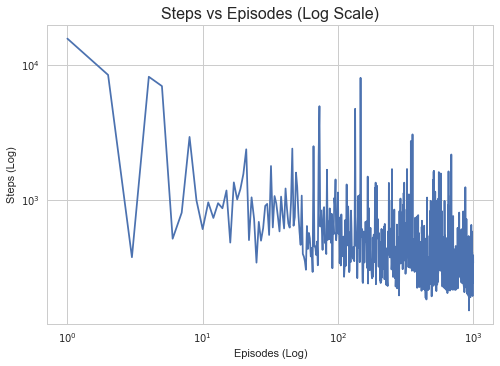

In [20]:
# Create graph for step vs episodes
y = count_step
x = np.arange(1, len(y) + 1)

plt.plot(x, y)
plt.title("Steps vs Episodes (Log Scale)", fontsize=16)
plt.xlabel("Episodes (Log)")
plt.ylabel("Steps (Log)")
plt.xscale('log')
plt.yscale('log')

plt.show()

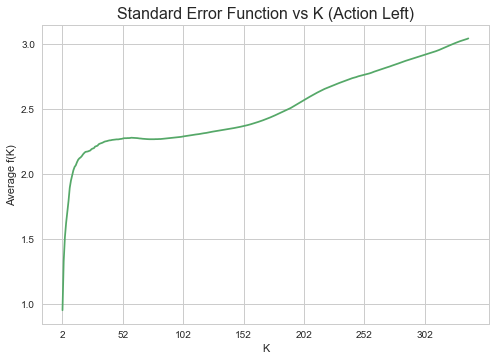

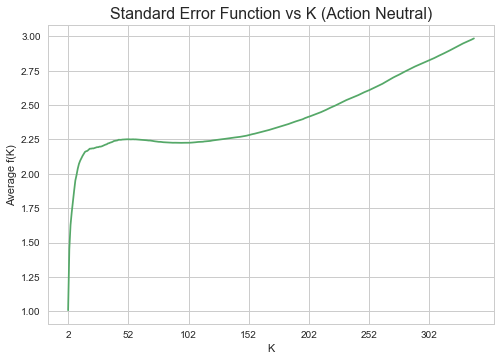

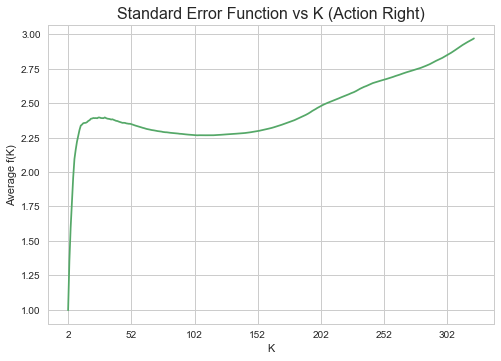

In [21]:
# Create plot for the standard error function
average_var_left = []
average_var_neutral = []
average_var_right = []

for elem in agent.var_function_left:
    average_var_left.append(elem/ total_step)

for elem in agent.var_function_neutral:
    average_var_neutral.append(elem/ total_step)

for elem in agent.var_function_right:
    average_var_right.append(elem/ total_step)

# Make a scatter plot
# Left
y = average_var_left
x = np.arange(2, len(y)+2)

plt.plot(x, y, color="#55A868")
plt.title("Standard Error Function vs K (Action Left)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()

# Make a scatter plot
# Neutral
y = average_var_neutral
x = np.arange(2, len(y)+2)

plt.plot(x, y, color="#55A868")
plt.title("Standard Error Function vs K (Action Neutral)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()


# Make a scatter plot
# Right
y = average_var_right
x = np.arange(2, len(y)+2)

plt.plot(x, y, color="#55A868")
plt.title("Standard Error Function vs K (Action Right)", fontsize=16)
plt.xlabel("K")
plt.ylabel("Average f(K)")
plt.xticks(np.arange(2, len(y) + 2, 50))

plt.show()

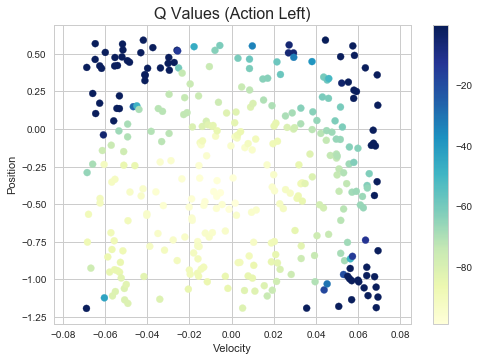

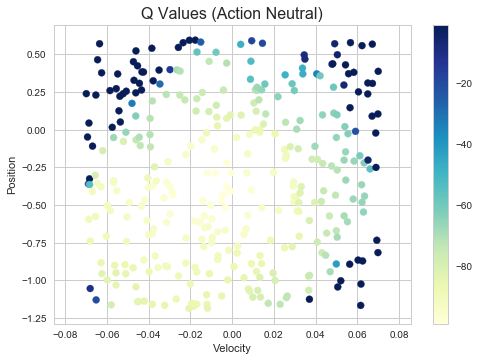

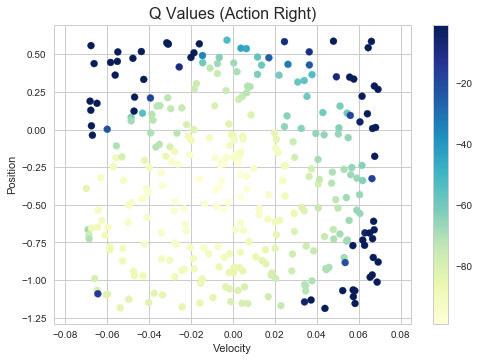

In [22]:
# Create heatmap for Q values
data = pd.DataFrame()
data_left = []
data_neutral = []
data_right = []

position_left = []
position_neutral = []
position_right = []

velocity_left = []
velocity_neutral = []
velocity_right = []

# Sort q_storage based on position and velocity
q_storage_sorted = sorted(agent.q_storage, key=lambda k: k['state'][0])  
# Separate action left, neutral, and right
for elem in q_storage_sorted:
    if (elem["action"] == -1):
        data_left.append(elem["value"])
        position_left.append(elem["state"][1])
        velocity_left.append(elem["state"][0])
    elif (elem["action"] == 0):
        data_neutral.append(elem["value"])
        position_neutral.append(elem["state"][1])
        velocity_neutral.append(elem["state"][0])
    else:
        data_right.append(elem["value"])
        position_right.append(elem["state"][1])
        velocity_right.append(elem["state"][0])

# Make scatter plot for 3 actions (left, neutral, right)
# Left
plt.scatter(x=velocity_left, y=position_left, c=data_left, cmap="YlGnBu")
plt.title("Q Values (Action Left)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

# Neutral
plt.scatter(x=velocity_neutral, y=position_neutral, c=data_neutral, cmap="YlGnBu")
plt.title("Q Values (Action Neutral)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

# Right
plt.scatter(x=velocity_right, y=position_right, c=data_right, cmap="YlGnBu")
plt.title("Q Values (Action Right)", fontsize=16)
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.colorbar()

plt.show()

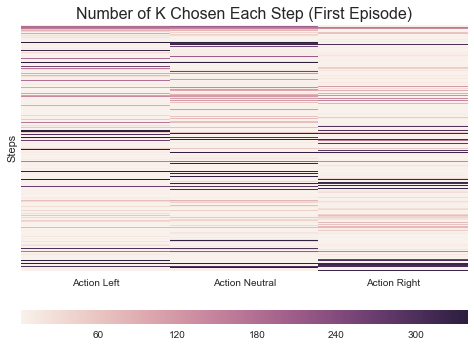

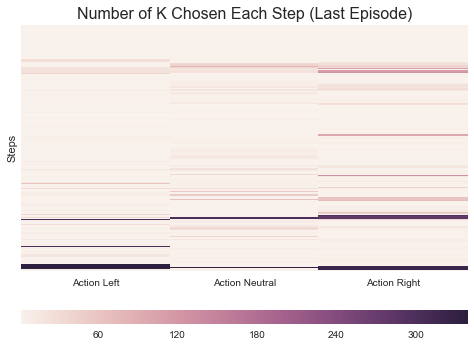

In [23]:
# Create heatmap showing the k (first episode)
data = pd.DataFrame()
data["Action Left"] = k_first_left
data["Action Neutral"] = k_first_neutral
data["Action Right"] = k_first_right
data["Steps"] = np.arange(1, len(k_first_left) + 1)
data.set_index("Steps", inplace=True)

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(data, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, yticklabels=False)
ax.set_title("Number of K Chosen Each Step (First Episode)", fontsize=16)

plt.show()

# Create heatmap showing the k (last episode)
data = pd.DataFrame()
data["Action Left"] = k_last_left
data["Action Neutral"] = k_last_neutral
data["Action Right"] = k_last_right
data["Steps"] = np.arange(1, len(k_last_left) + 1)
data.set_index("Steps", inplace=True)

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(data, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, yticklabels=False)
ax.set_title("Number of K Chosen Each Step (Last Episode)", fontsize=16)

plt.show()